# 闲话python 41：tensorflow2.0加载numpy数据

numpy是python中进行数值计算的基础库，numpy格式的数据也是python开发者常用的数据格式。使用这种格式存储的数据文件该怎样用于tensorflow的机器学习系统呢？本文就是讨论在tensorflow2.0中加载numpy数据，并使用该数据进行模型训练和评估。本文是参照tensorflow官网教程完成编写的，主要的代码逻辑与官网一致，感兴趣并且网速合适的朋友也可以直接阅读tensorflow官网的教程。本文所使用的数据可以从https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz 下载。

## 1. 从文件载入numpy数据

numpy为npz格式的数据提供了载入接口，这里就是使用numpy.load()函数将数据从文件载入到内存。查看一下训练集和测试机数据及格式一致，样本数量符合预期。使用matplotlib可视化训练集的前6个样本数据，标记与图像是匹配的，因此从文件到内存的数据载入过程正确。

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


<IPython.core.display.Javascript object>


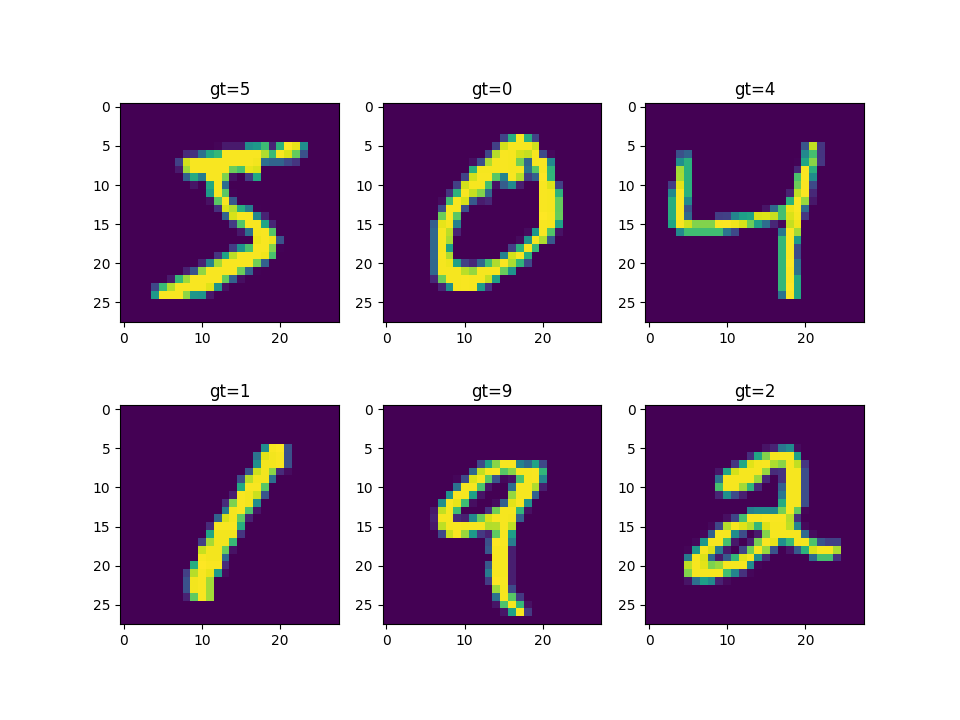

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

# 下载地址：https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
data_path = '../../data/mnist.npz'
with np.load(data_path) as data:
    imgs_tr = data['x_train']
    lbls_tr = data['y_train']
    imgs_te = data['x_test']
    lbls_te = data['y_test']
print(imgs_tr.shape)
print(lbls_tr.shape)
print(imgs_te.shape)
print(lbls_te.shape)
# 可视化训练集前若干个样本
plt.figure(figsize=(9.6, 7.2))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(imgs_tr[i, ...])
    plt.title('gt={}'.format(lbls_tr[i]))
plt.show()

## 2. 创建数据集

tensorflow提供了tf.data.Dataset.from_tensor_slices()函数将numpy格式的数据包装成Dataset，以便于后面的调用。对于训练集除指定batch size之外，还需要将样本随机排列。使用matplotlib可视化训练数据集的前几个样本，发现与上文中显示的不相同，说明随机排列设置生效。

<IPython.core.display.Javascript object>


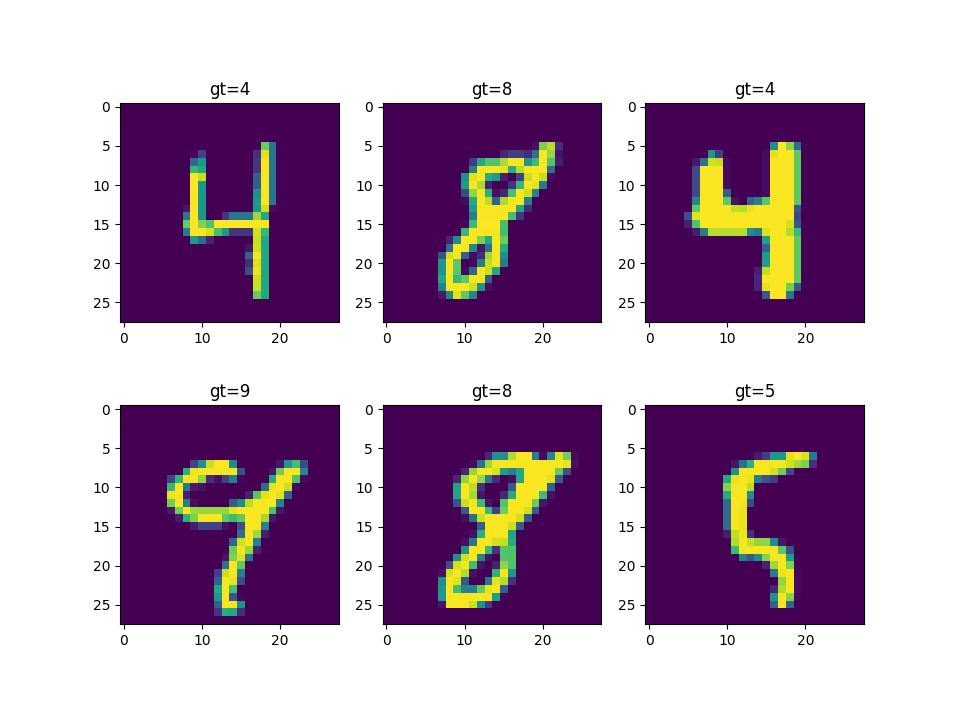

In [11]:
import tensorflow as tf

trainset = tf.data.Dataset.from_tensor_slices((imgs_tr, lbls_tr))
testset = tf.data.Dataset.from_tensor_slices((imgs_te, lbls_te))
trainset = trainset.shuffle(100).batch(64)
testset = testset.batch(64) 
# 可视化训练数据集的前若干个样本
for imgs, lbls in trainset:
    break
plt.figure(figsize=(9.6, 7.2))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(imgs[i, ...])
    plt.title('gt={}'.format(lbls[i]))
plt.show()

## 3. 训练模型及测试

数据集准备完成之后，就可以使用该数据集训练模型了。这里使用tensorflow中的keras子模块创建一个简单的神经网络，设置好优化器和损失函数之后就可以进行训练了。训练完成之后，在测试集上对该模型进行评估，所得到的正确率与训练过程基本一致，符合预期。

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(optimizer=RMSprop(), 
              loss=SparseCategoricalCrossentropy(), 
              metrics=[SparseCategoricalAccuracy()])
model.fit(trainset, epochs=10)
model.evaluate(testset)

Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 3.1630 - sparse_categorical_accuracy: 0.8721
Epoch 2/10
938/938 [==============================] - 2s 3ms/step - loss: 0.5051 - sparse_categorical_accuracy: 0.9275
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.3821 - sparse_categorical_accuracy: 0.9467
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.3283 - sparse_categorical_accuracy: 0.9540
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2980 - sparse_categorical_accuracy: 0.9601
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2786 - sparse_categorical_accuracy: 0.9632
Epoch 7/10
938/938 [==============================] - 2s 3ms/step - loss: 0.2591 - sparse_categorical_accuracy: 0.9681
Epoch 8/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2267 - sparse_categorical_accuracy: 0.9694
Epoch 9/10
938/938 [============================

[0.659032178015553, 0.9559]

使用训练好的模型进行预测过程的测试。使用测试集的第一个batch作为模型的输入，对比模型输出与真实标签，发现绝大部分都预测正确，小部分预测错误，比例基本与评估显示的错误率一致。

In [9]:
for imgs, lbls in testset:
    break
preds = np.argmax(model.predict(imgs), axis=1)
print('预测结果：', preds)
print('真值标签：', lbls.numpy())

预测结果： [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 3 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 3 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 2 5 2]
真值标签： [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3]


到此，在tensorflow2.0中加载numpy数据用于模型训练就讨论完毕。使用的过程和操作方式都很简单，在日常的工作和科研过程中，使用这种方式确实可以较大地提高工作效率。不过需要指出的是，这种方式会将数据一次载入内存，如果数据量比较大，内存压力过大可能会出现程序崩溃。因此，这种方式适合数据量不太大的项目，如果内存不足以容纳这么多的数据，就需要考虑别的方法了。本文的notebook文件在github上的cnbluegeek/notebook仓库中共享，欢迎感兴趣的朋友前往下载。